CPT
====

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms
import pandas as pd
import pickle
import gstools
from gstools import Exponential, Gaussian
from cycler import cycler
from string import ascii_lowercase
from matplotlib.cm import get_cmap

plt.style.use('./mpl/manuscript.mplstyle')
path = '../../data/cpt'
name = 'GH_T_PCPT7'

#plt.rcParams['figure.figsize'] = plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][0] * 2

"trans = lambda ax: transforms.blended_transform_factory(fig.transFigure, ax.transAxes)\nrow1.text(0, 1, 'a)', transform=trans(row1))\nrow2.text(0.5, 1, 'b)', transform=trans(row2))\nrow3.text(0, 1, 'c)', transform=trans(row3))"

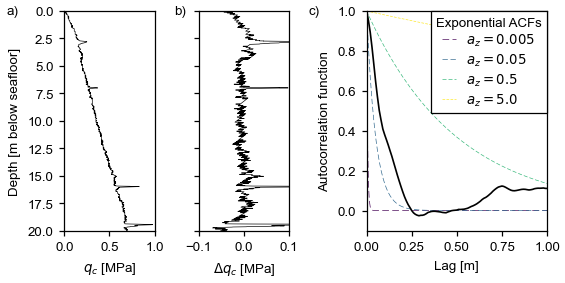

In [2]:
cpt = pd.read_csv(os.path.join(path, name + '.csv'), index_col=0)
coefficients = np.polyfit(cpt.index.values, cpt['qc'].values, 3)
detrended_cpt = cpt['qc'] - np.array([m * cpt.index ** z for z, m in enumerate(coefficients[::-1])]).sum(axis=0)

fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 2])

row1 = fig.add_subplot(gs[0, 0])
row1.set(xlim=(0, 1), ylim=(0, 20), ylabel='Depth [m below seafloor]')

row2 = fig.add_subplot(gs[0, 1], sharey=row1)
plt.setp(row2.get_yticklabels(), visible=False)

row3 = fig.add_subplot(gs[0, 2:])

for ax in row1, row2:
    ax.set_ylim(0, 20)
row1.invert_yaxis()
    
lag = np.linspace(0, 1, 200)
handles = []

cmap = get_cmap('viridis')
custom_cycler = (cycler('color', cmap(np.linspace(0, 1, 4))) +
    cycler('dashes', [(10, 5), (8, 4), (6, 3), (4, 2)]))
row3.set_prop_cycle(custom_cycler)

for a_z in 5e-3, 5e-2, 5e-1, 5e0:
    model = Exponential(dim=1, len_scale=a_z)
    row3.plot(lag, model.correlation(lag), '--', label=f'$a_z={a_z}$',
      linewidth=0.4, alpha=1)
    

leg = row3.legend(title='Exponential ACFs', loc='upper right', borderaxespad=0, handlelength=1)

row3.set(xlabel='Lag [m]', xlim=(lag.min(), lag.max()),
         ylabel='Autocorrelation function', ylim=(-0.1, 1))

row1.plot(cpt['qc'].values, cpt.index.values, 'k-', linewidth=0.4)[0],
row1.set(xlabel='$q_c$ [MPa]')

row2.plot(detrended_cpt.values, detrended_cpt.index.values, 'k-', linewidth=0.4)
row2.set(xlabel='$\Delta q_c$ [MPa]', xlim=(-0.1, 0.1))

n = len(detrended_cpt)
acf = np.convolve(detrended_cpt.values, detrended_cpt.values[::-1], mode='full')
acf /= acf.max()
acf = acf[n - 1:]
lag = np.arange(len(acf)) * (detrended_cpt.index.values[1] - detrended_cpt.index.values[0])
row3.plot(lag, acf, 'k', linestyle='solid', dashes='', linewidth=1, zorder=999)[0]

def label_axis(axis, i, offset=(-35, 0), second=False):
    trans = transforms.blended_transform_factory(axis.transAxes, axis.transAxes)
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=offset,
                  xycoords=trans, textcoords='offset points',
                  va='center', ha='left')
    return i + 1
    
counter = 0
counter = label_axis(row1, counter)
counter = label_axis(row2, counter, offset=(-15, 0))
counter = label_axis(row3, counter)

"""trans = lambda ax: transforms.blended_transform_factory(fig.transFigure, ax.transAxes)
row1.text(0, 1, 'a)', transform=trans(row1))
row2.text(0.5, 1, 'b)', transform=trans(row2))
row3.text(0, 1, 'c)', transform=trans(row3))"""

In [3]:
fig.savefig('../../manuscript/figures/si_fig02.pdf')